# 0. Setup

## Imports

In [1]:
import os
import time
import random
import gc
import multiprocessing
from collections import Counter

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision
from torchvision import datasets, models, transforms

import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, Subset, SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path
from google.colab import drive
from shutil import copyfile

import pandas as pd
from pandas import DataFrame
import seaborn as sns

from functools import partial

## Setup GPU

In [2]:
use_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
if device.type == 'cuda':
  print('CUDA is available. Training on GPU')
else:
  print('CUDA is not available. Training on CPU')

CUDA is available. Training on GPU


# 1. Download Data

### Download Data from Google Drive

In [3]:
def download_data(train=True):
    """ Function to download data from google drive
        Args:
            train: specifies whether to download train or test data
    """
    gdrive_path = Path('./drive')
    # gdrive_dir = 'aps360'
    gdrive_dir = 'Colab Notebooks'

    # mount your google drive to colab 
    drive.mount(gdrive_path.as_posix())
    gdrive_path  /= 'My Drive'

    if train:
        # file_name = 'aps360_project_db_train.zip'
        file_name = 'demo.zip'
    else:
        file_name = 'aps360_project_db_test.zip'

    # get file path
    data_path = gdrive_path / gdrive_dir / file_name

    # copy dependencies from gdrive into colab 
    os.makedirs('./rawdata', exist_ok=True)
    copyfile(data_path, "./rawdata/" + file_name)

    # unmount gdrive
    drive.flush_and_unmount()

def unzip_data(train=True):
    """ Function to unzip dataset
        Args:
            train: specifies whether to download train or test data
    """
    if train:
        # ! unzip /content/rawdata/aps360_project_db_train.zip
        ! unzip /content/rawdata/demo.zip
        ! rm -rf /content/rawdata/
    else:
        ! unzip /content/rawdata/aps360_project_db_test.zip
        ! rm -rf /content/rawdata/

def delete_data(train=True):
    """ Function to delete dataset
        Args:
            train: specifies whether to download train or test data
    """
    if train:
        ! rm -rf /content/TRAIN
    else:
        ! rm -rf /content/TEST



### Download demo data  

.    
└── 📁 TRAIN    
  ├── 📁 O  
  └── 📁 R   

In [4]:
%%capture
download_data(train=True)
unzip_data(train=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g43yuSPrZ65esNcqMy4oLJKwasoJ9AUAnSeC4OB2Ol8TffIFzaSiTY


### Download test data  

.    
└── 📁 TEST    
  ├── 📁 O  
  └── 📁 R   

In [5]:
%%capture
download_data(train=False)
unzip_data(train=False)

# 2. Split Data

In [6]:
def create_dataset(train=True):
    """ Load data from file system and create a dataset
    Args:
        train: choose between training set and test set
    Returns:
        dataset 
    """
    # convert images to (224 x 224)
    data_transform = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ColorJitter(brightness=0.1, hue=0.05, saturation=0.01),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(35),
                                        transforms.ToTensor()])

    return datasets.ImageFolder(test_data_dir, transform=data_transform)
  
def split_data(dataset, train=True, train_ratio=0.7, batch_size=25, 
                                                    seed=1000, shuffle=True):
    """ Load data from dataset and split it into train/valid/test sets
    Args:
        dataset: dataset containing all data
        train: determines if dataset is for the train or the test set. 
                If it's the test set, don't split
        train_ratio: percentage of data to go into training set
        batch_size: batch size for dataloader
        seed: random seed
        shuffle: flag on whether the shuffle original dataset or not
    Returns:
        train_loader: training dataloader
        valid_loader: validation dataloader
        test_loader: test dataloader    
    """
    # number of examples in dataset
    num_data = len(dataset)

    # shuffle data
    if shuffle:
        torch.manual_seed(seed)
        indices = torch.randperm(num_data)
    else:
        indices = torch.arange(num_data)

    # dataloader parameters
    num_workers = multiprocessing.cpu_count()
    prefetch_factor = 8
    pin_mem = False
    if torch.cuda.is_available():
        pin_mem = True

    # all data placed in test set
    test_idx = indices
    test_sampler = SubsetRandomSampler(test_idx)

    test_loader = DataLoader(dataset, 
                              batch_size=batch_size, 
                              sampler=test_sampler, 
                              num_workers=num_workers, 
                              pin_memory=pin_mem,
                              prefetch_factor=prefetch_factor)
    
    return test_loader

In [7]:
# create demo dataset
demo_transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor()])

demo_dir = "/content/demo2/DEMO"
demo_dataset = datasets.ImageFolder(demo_dir, transform=demo_transform) 

# 3. Visualize Data

Number of demo examples: 10


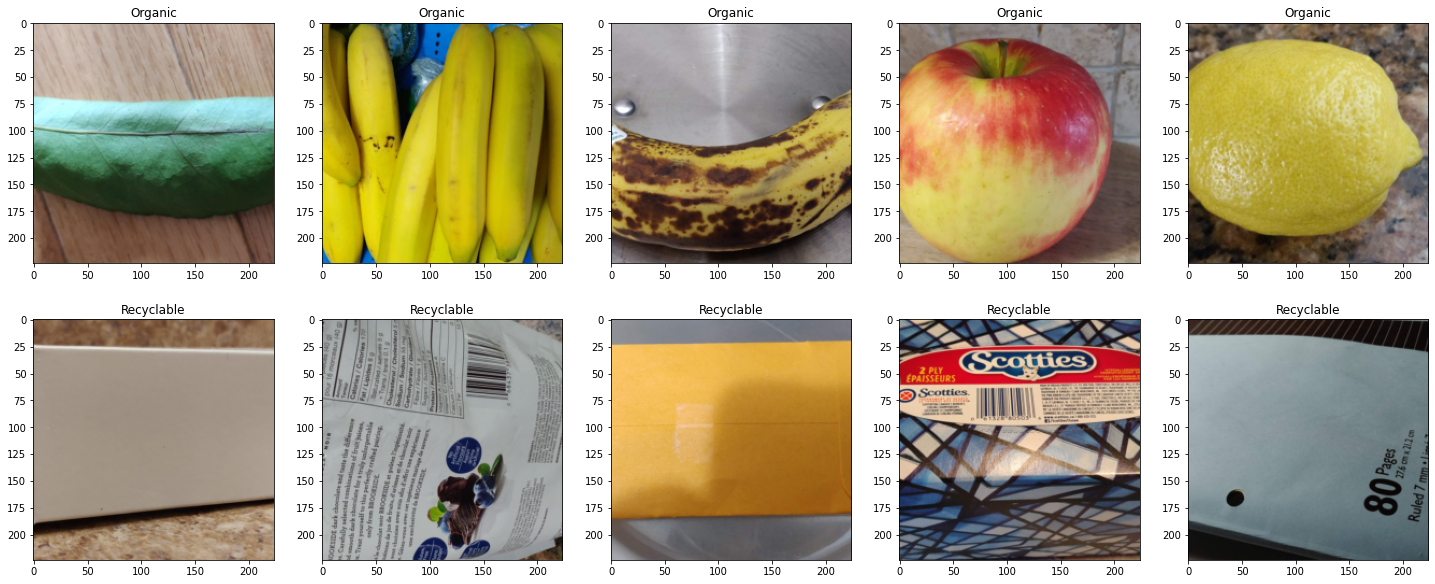

In [9]:
# test_dataset = create_dataset(train=False)
demo_loader = DataLoader(demo_dataset)
print(f"Number of demo examples: {len(demo_loader)}")

classes = ['Organic', 'Recyclable']
batch_size = 1
# Use alternative values if using the old demo zip file
num_sample_batches = 10 # or 2
num_cols = 5 # or 2
num_rows = num_sample_batches / num_cols

train_iter = iter(demo_loader)
fig = plt.figure(figsize=(25, 10))

for i in range(num_sample_batches):
    for j in range(batch_size):
      imgs, labels = train_iter.next()
      ax = fig.add_subplot(num_rows, num_cols, i + 1)
      plt.imshow(np.transpose(imgs[j], (1, 2, 0)))
      ax.set_title(classes[labels[j]])

# 4. Define Model

In [10]:
def get_num_params(net):
    """determine the size of the model
    Args:
        net: machine learning model
    Returns:
        size of model
    """
    return sum(p.numel() for p in net.parameters())

In [11]:
# Base CNN model
class CNN(nn.Module):
    def __init__(self, nin: int, nout: int, k=5, s=1):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(nin, nout, kernel_size=k, stride=s)

    def forward(self, x):
        x = F.relu(self.conv(x))
        return x 

class WasteClassifier(nn.Module):
    def __init__(self, get_size=False):
        super(WasteClassifier, self).__init__()
        self.get_size = get_size
        self.resnet_feature_extractor = models.resnet18(pretrained=True)
        self.resnet_feature_extractor = nn.Sequential(*list(self.resnet_feature_extractor.children())[:-3])
        for param in self.resnet_feature_extractor.parameters():
            param.requires_grad = False

        self.conv = nn.Sequential(
            CNN(nin=256, nout=512),
            nn.MaxPool2d(2, 2),
            CNN(nin=512, nout=512),
            nn.Dropout()
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def forward(self, x):
        x = self.resnet_feature_extractor(x)
        if self.get_size:
            print("resnet feature layer size: ", x.size())
        x = self.conv(x)
        x = self.flatten(x)
        if self.get_size:
            print("flattened layer size: ", x.size())
        x = self.fc(x)
        x = x.squeeze(1)  # Flatten to [batch_size]
        return x

In [12]:
print(f"Number of parameters in model: {get_num_params(WasteClassifier())}")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Number of parameters in model: 12647105


# 5. Experimentation

In [13]:

def load_model(model, PATH, device):
    """ Load a previously saved model
    Args:
        model: model with same architecture as the one you're trying to load
        PATH: file path to load from
        device: device (cpu or gpu) to load the model into
    """
    model.load_state_dict(torch.load(PATH, map_location=device))

In [14]:
@torch.no_grad()
def test_accuracy(model, test_loader):
    """ Compute accuracy of the model on the test set
     Args:
        model: machine learning model
        test_loader: dataloader for the test set
     Returns:
         acc: the accuracy of the model
     """
    total_acc = 0.0
    total_examples = 0
    for imgs, labels in test_loader:
        # use GPU if available
        imgs = imgs.to(device)
        labels = labels.to(device)

        # get predictions
        out = model(imgs)

        # converts to 0 (organic) or 1 (recyclable) and compares with label
        pred = (out >= 0.0).squeeze().long() == labels 

        # calculate accuracy
        total_acc += sum(pred).item()
        total_examples += len(labels)

    acc = float(total_acc) / total_examples   
    return acc

@torch.no_grad()
def plot_confusion_matrix(model, dataloader):
    confusion_matrix = np.zeros((2, 2))
    
    for (imgs, labels) in dataloader:
        # use GPU if available
        imgs = imgs.to(device)
        labels = labels.to(device)

        # get predictions
        out = model(imgs)
        pred = (out >= 0.0).squeeze().long()
        for p, l in zip(pred, labels):
            confusion_matrix[p.long(), l.long()] += 1

    # plot heatmap
    plt.figure(figsize=(9,6))
    classes = ['organic', 'recyclable']
    df = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
    heatmap = sns.heatmap(df, annot=True, fmt="d")

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0)
    plt.xlabel('Real label')
    plt.ylabel('Predicted label')

    # calculate accuracy
    TP = confusion_matrix[0][0]
    TN = confusion_matrix[1][1]
    acc = (TP + TN) / confusion_matrix.sum()
    print(f"Accuracy: {acc:.8f}")


In [15]:
best_model = WasteClassifier()
load_model(best_model, "/content/best_model", device)
best_model.to(device)

print(f"Demo Accuracy: {test_accuracy(best_model, demo_loader):.8f}")

Demo Accuracy: 0.70000000


Accuracy: 0.92996419


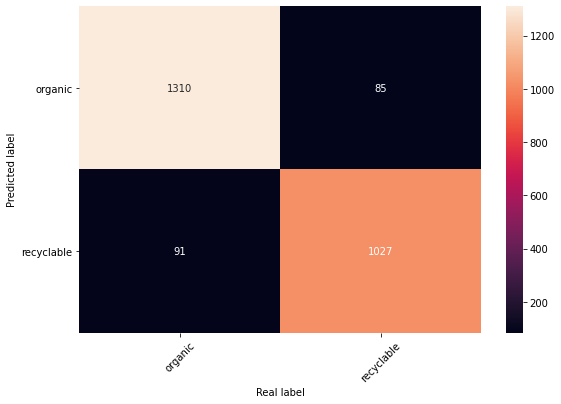

In [18]:
params = {'batch':62, 'seed':10}

test_data_dir = "/content/TEST"
test_dataset = create_dataset(train=False)
test_loader = split_data(test_dataset,
                        train=False,
                        batch_size=params.get('batch'), 
                        seed=params.get('seed'),
                        shuffle=True)
plot_confusion_matrix(best_model, test_loader)